In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4*4,4.8*1.5)

import numpy as np
from scipy import special

In [6]:
def fir_window_method(L, fc, fs=1):
	Lo = (L-1)//2
	hspace = np.linspace(-Lo, Lo, num=L)
	hideal = 2 * fc / fs * np.sinc(2 * fc * hspace / fs)
	_, hamm = win.hamming(L)
	h = hamm * hideal
	return h


In [7]:
def lowpass_kernel(sig, fc, fs=1) -> None:
    # signal length
    M = window_size_samples

    # filter params
    L = window_size_samples + 1

    h = fir_window_method(L, fc, fs)

    # apply filter
    Nfft = util.nextpow2(L + M - 1)
    print(f'Nfft={Nfft}')
    # zero pad
    xzp = np.concatenate((sig, np.zeros(Nfft-M)))
    hzp = np.concatenate((h, np.zeros(Nfft-L)))

    X = np.fft.fft(xzp)
    H = np.fft.fft(hzp)

    Y = X * H

    y = np.fft.ifft(Y)
    #relrmserr = np.norm()
    #print(relrms)

    y = np.real(y)

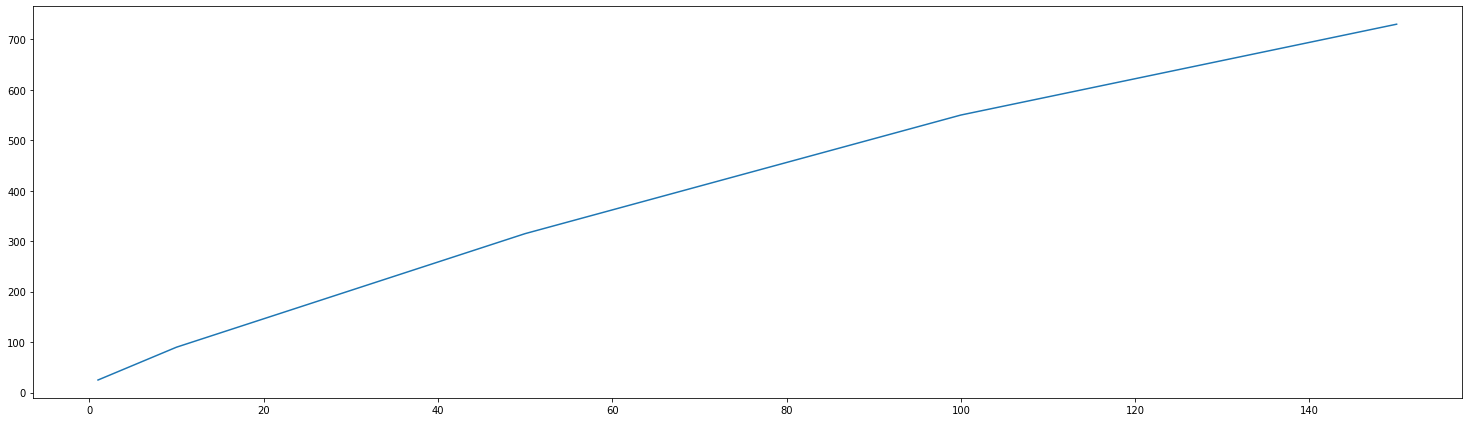

In [8]:
# drive conditions that produce the maximum amplitude signal
BIAS = 0.82
UNITY_AMPLITUDE = 0.1
FRAME_LENGTH = 0.0055
FRAME_RATE = 179
DAC_RATE = 781250
DAC_HOLD = 4
DAC_SMOOTH = 4
DAC_BANDWIDTH = DAC_RATE / DAC_HOLD / DAC_SMOOTH

DDS_VALS = [1, 10, 50, 100, 150]
DDS = [25, 90, 315, 550, 730]
plt.plot(DDS_VALS, DDS)

In [79]:
def oscillator_bank(N, freqs, amps, process=None):
	k = np.arange(N)
	harmonics = len(freqs)
	oscillators = [amp * np.sin(np.pi * freq * k) for freq, amp in zip(freqs, amps)]
	return np.sum(np.array(oscillators), axis=0)

1.081314500215937


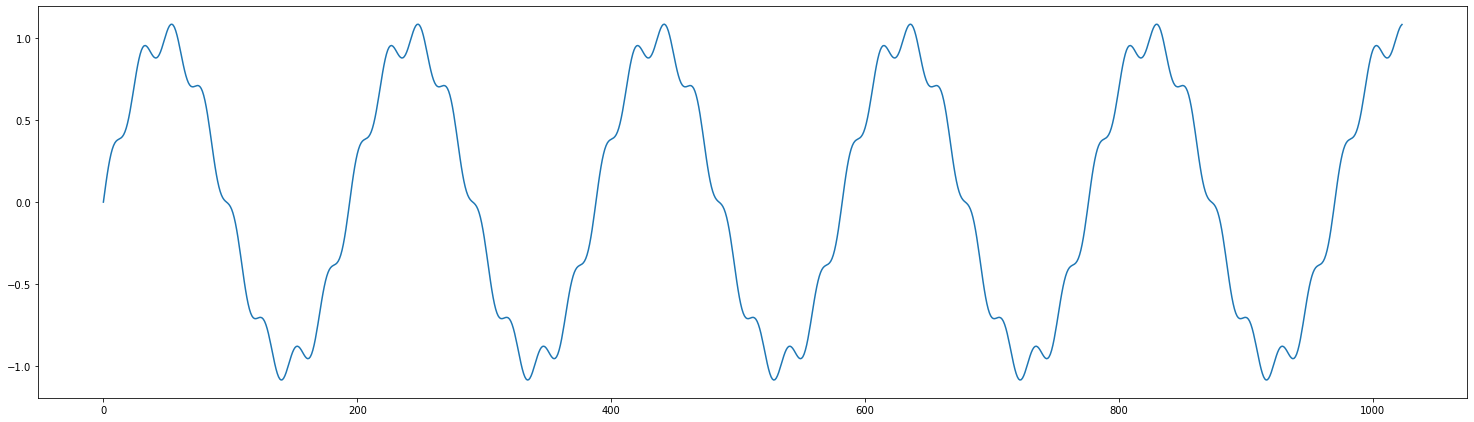

In [80]:
freq = 8e3
k1 = DAC_RATE // freq
k2 = DAC_RATE // freq / 8
sig = oscillator_bank(1024, np.array([1/k1, 1/k2]), np.array([1, 0.1]))
print(sig[-1])
plt.figure()
plt.plot(sig)

In [81]:
def random_phase_multisine(N, P=1, gain=1, fs=1, process=None):
    '''
        N: number of "time samples" in one signal period

        P: number of time domain periods to generate

        With a normalized amplitude spectrum, the DFT coefficient magnitudes U(k*fs/N) are scaled by 1/sqrt(N)
        U(k*fs/N) are uniformley bounded with a finite number of discontinuities on [0, fs/2].
        Further, the clock frequency fs is independent of N.

        Phase mean drawn from the random process must = 0
    '''

    # spectral resolution = 2*pi / N

    # F is the number of unique spectral lines between [0, fs/2)
    if process is None:
        process = np.random.default_rng()

    # N is even
    # results in N2 number of "real" spectral lines, but we later set dc component to 0
    N2 = (N - 1) // 2
    # sample positive frequencies up to fs, skipping dc
    k = process.integers(low=1, high=N, size=N2)

    # signal is real, so its spectrum is hermitian
    # negative frequencies are conjugate symmetric
    # magnitude is even while the phase is odd
    positive_spectrum = np.exp(1j * 2 * np.pi * k / N)
    print(len(positive_spectrum))
    negative_spectrum = np.conj(np.flip(positive_spectrum))
    # create oscillator bank with dc value U[0] = 0
    # assume 0 phase for the real time-domain signal
    U = np.array([0] + list(positive_spectrum) + list(negative_spectrum), dtype=np.complex128)

    # extract the continuous time domain signal corresponding to the constructed fourier series (hermitian spectrum)
    # norm of "ortho" applies a 1/sqrt(N) scaling, as desired

    U = np.fft.fftshift(U)
    u = np.fft.ifft(U, norm="ortho")
    return u, U

In [82]:
def plot_excitation(u, U):
	plt.figure()
	plt.grid()
	plt.title('Time Series Signal (V)')
	plt.plot(np.real(u) / np.pi, marker='o')

	plt.figure()
	plt.grid()
	plt.title('Phase (rad/s)')
	phase = np.angle(U)#np.angle(checkfft)
	plt.plot(phase, marker='o')
	plt.axvline(x=len(phase) // 2)

	plt.figure()
	plt.grid()
	plt.title('Amplitude Response (Gain)')
	plt.plot(np.abs(U), marker='o')

	plt.figure()
	plt.grid()
	plt.title('Test Response (Gain)')
	checkfft = np.fft.fft(u, norm="ortho")
	plt.plot(np.abs(checkfft), marker='o')


In [76]:
def write_to_c_array(data, holdcount=1, filename=None):
    if filename is None:
        filename = "table.c"

    tablefile = open(filename, "w")
    tablefile.write("#include <stdint.h>\n\n")
    tablefile.write(f'unsigned DRIVE_LUT_SIZE = {len(data) * holdcount};\n')
    tablefile.write(f'uint16_t DRIVE_LUT[{len(data) * holdcount}] = {"{"} \\')
    for index in np.arange(len(data)):
        val = data[index]
        chunk = holdcount * f'{int(val)},'
        if index % 32:
            tablefile.write(chunk)
        else:
            tablefile.write(f'\n{chunk}')
    tablefile.write("\n};")
    tablefile.close()

In [83]:
def write_dac_table(u, idx):
	u_out = np.real(u) / np.pi

	u_out *= UNITY_AMPLITUDE

	u_out = np.concatenate((u_out, u_out))
	u_out += BIAS
	dac_table = np.round(u_out * 4095 / 3.3)
	write_to_c_array(dac_table, filename=f'table{idx}.c')

In [84]:
N = 253
tables = [random_phase_multisine(N=N) for _ in range(10)]

with open("tables.npy", "wb") as fd:
	for idx, sig in enumerate(tables):
		u, U, _, _ = sig
		np.save(fd, (u, U))
		write_dac_table(u, idx)

126
126
126
126
126
126
126
126
126
126
506
506
506
506
506
506
506
506
506
506


126


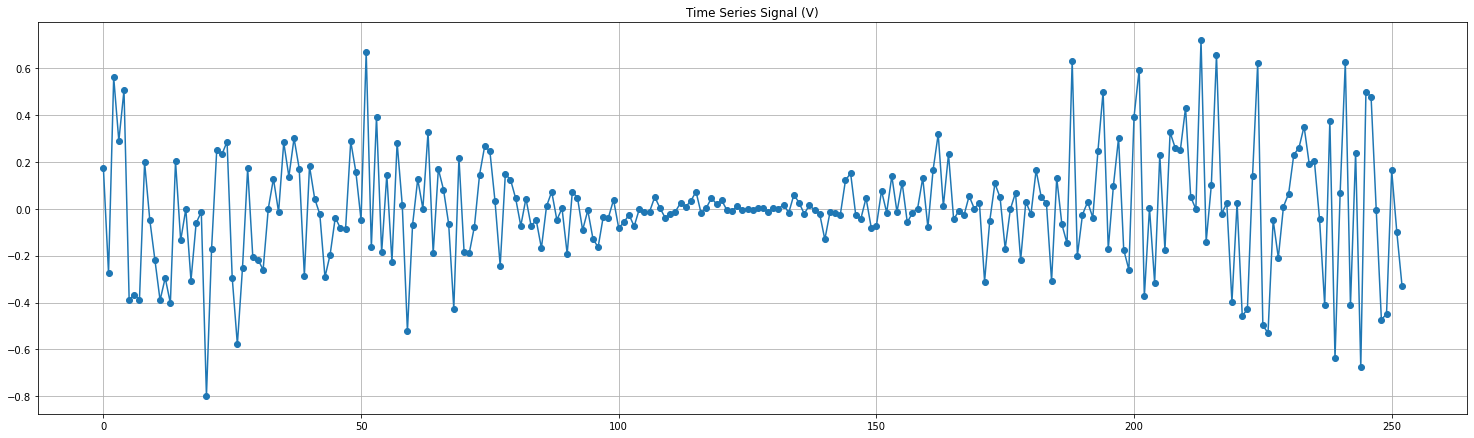

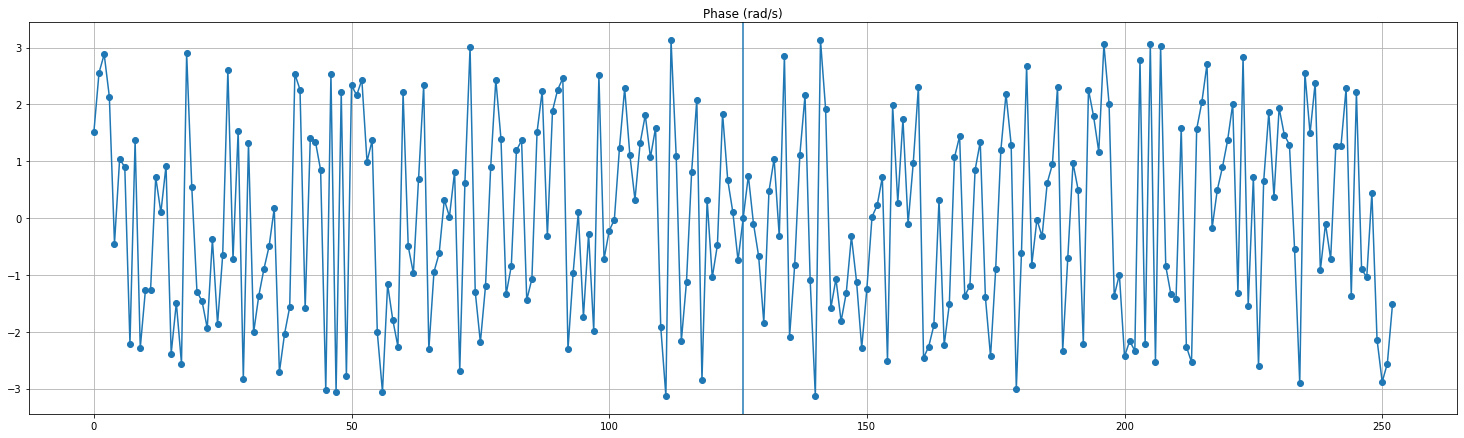

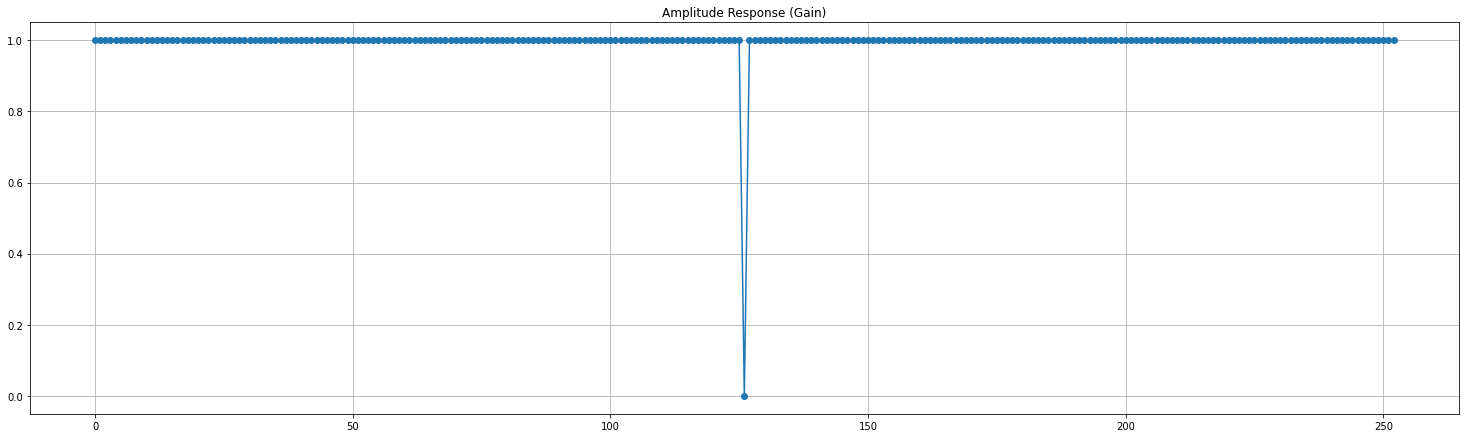

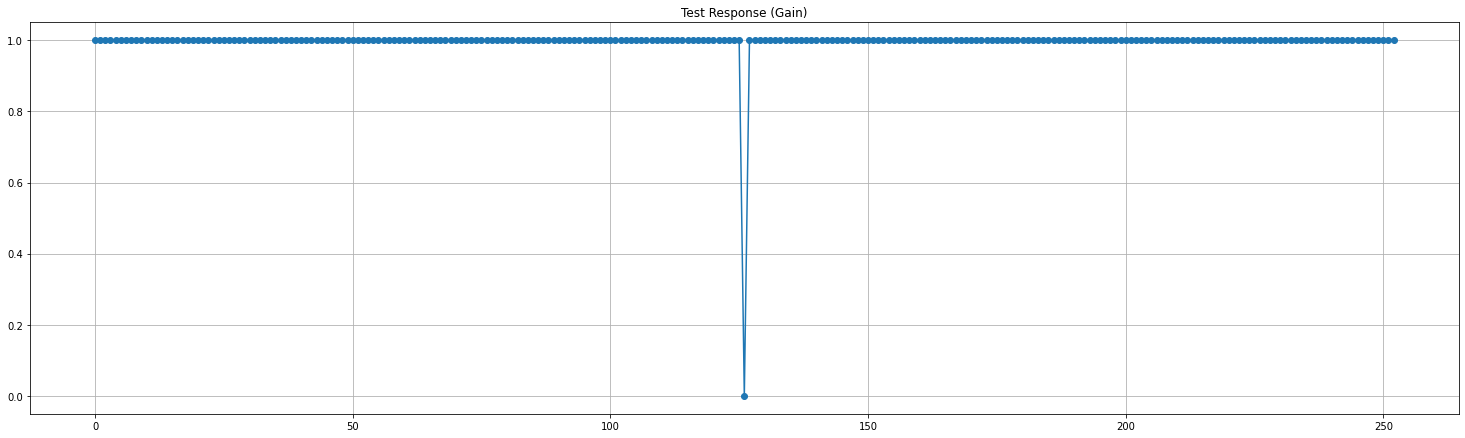

In [85]:

N = 253
u, U, _, _ = random_phase_multisine(N=N)
# the exact coordinate transformation is 2 * np.real(u)
# here we normalize to 1 instead of 2*pi
plot_excitation(u, U)

506


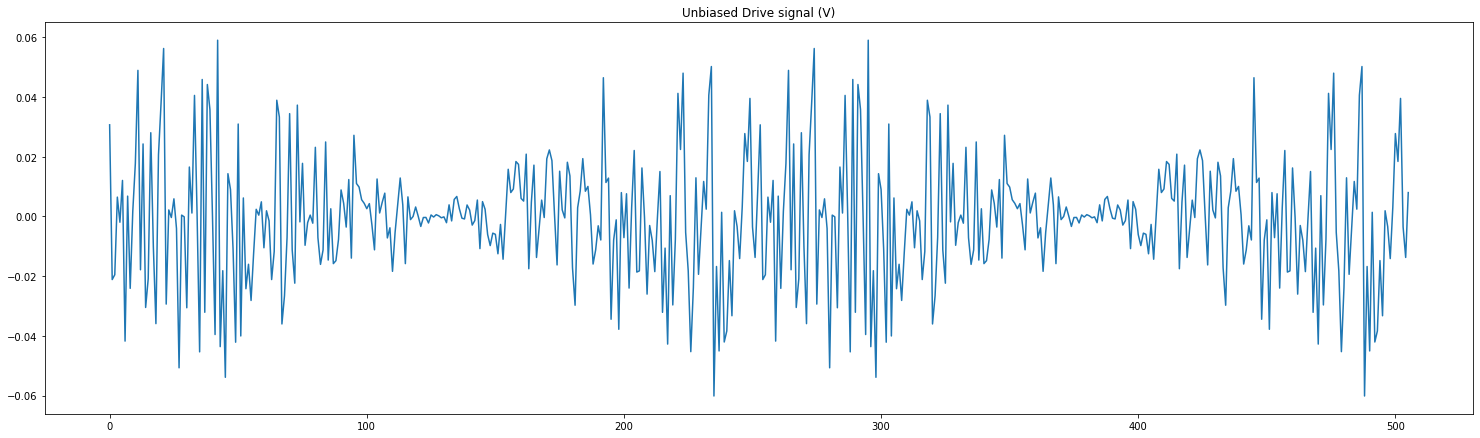

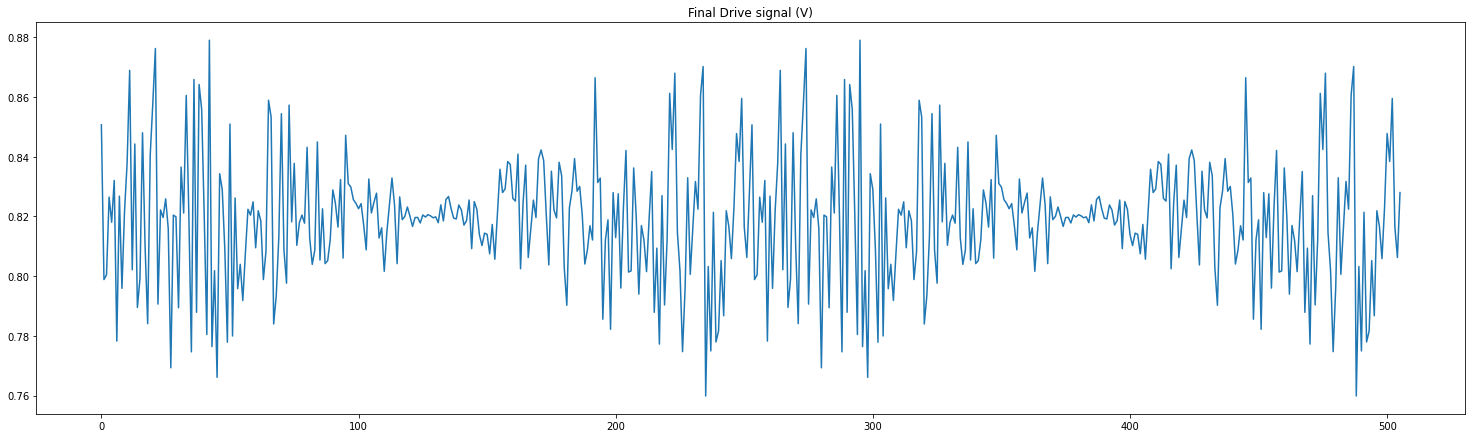

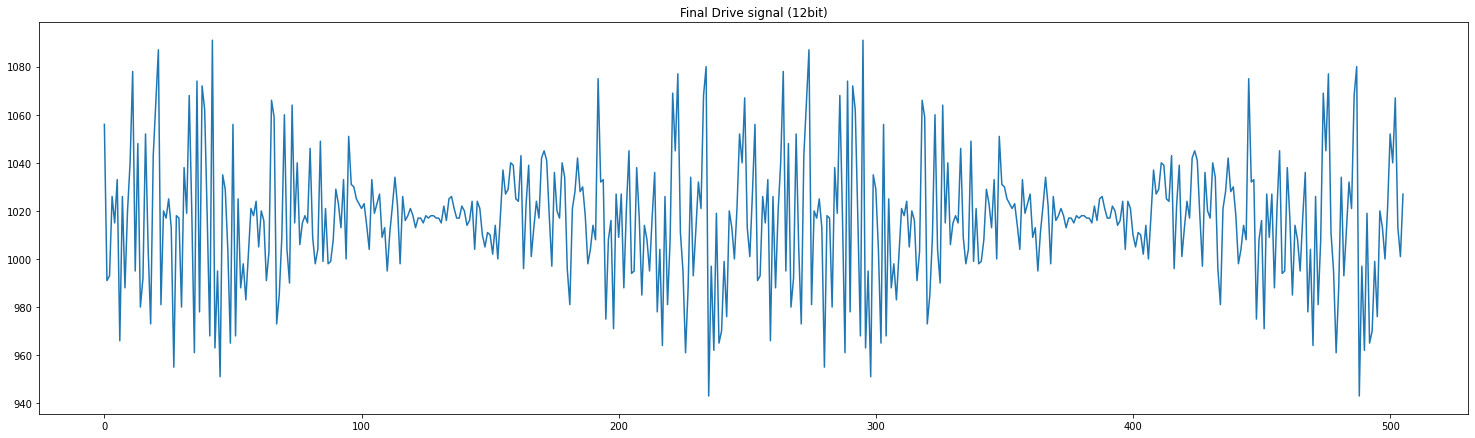

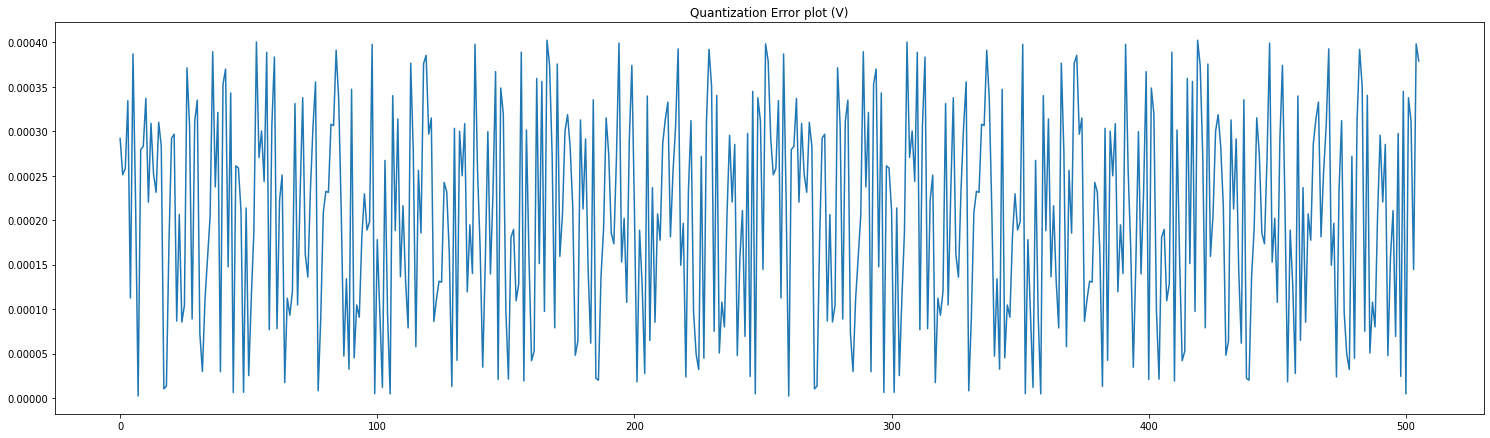

In [86]:

# transform to be output ready
u_out = ureal.copy()

u_out *= UNITY_AMPLITUDE

u_out = np.concatenate((u_out, u_out))
print(len(u_out))
plt.figure()
plt.title('Unbiased Drive signal (V)')
plt.plot(u_out)
u_out += BIAS
plt.figure()
plt.title('Final Drive signal (V)')
plt.plot(u_out)

dac_table = np.round(u_out * 4095 / 3.3)
plt.figure()
plt.title('Final Drive signal (12bit)')
plt.plot(dac_table)

plt.figure()
plt.title('Quantization Error plot (V)')
plt.plot(np.abs(dac_table * 3.3 / 4095 - u_out))

write_to_c_array(dac_table, holdcount=1)